- Using Machine Learning to Forecast Energy Consumption
- This notebook replicates Rob Mulla's original work which is accompanied by a YouTube tutorial.  

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt  

https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook


## Part 1

# Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Load Data

In [4]:
df = pd.read_csv('Downloads/PJME_hourly/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


Remove the index column and set it to Datetime column 

In [5]:
df = df.set_index('Datetime')
df.head()

In [13]:
df.dtypes

PJME_MW    float64
dtype: object

Convert data type of Datetime

In [15]:
df.index = pd.to_datetime(df.index)

Visualize the Data

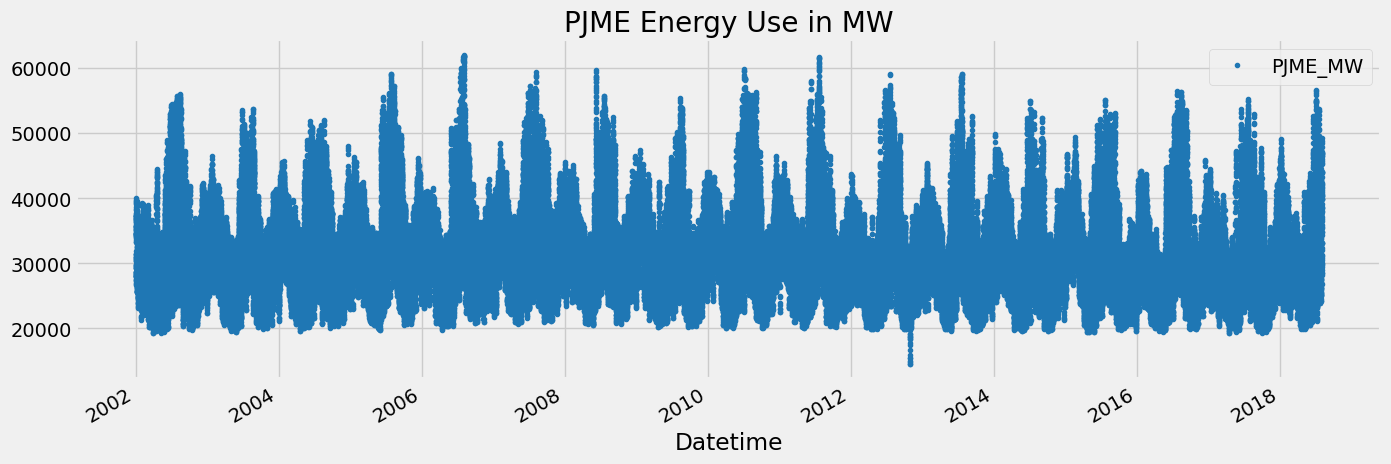

In [16]:
df.plot(style = '.',
        figsize= (15, 5), 
        color=color_pal[0],
        title = 'PJME Energy Use in MW')
plt.show()

# Train / Test Split

We split on the date January 2015 and have everything prior to January 2015 as Training data and keep our Test data as the following dates

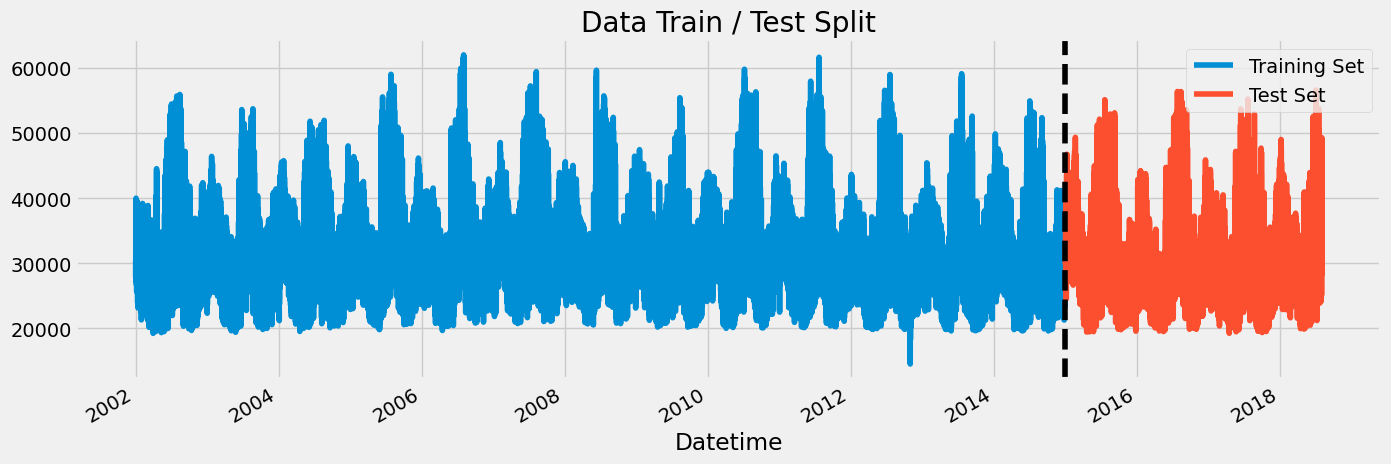

In [19]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train / Test Split')
test.plot(ax = ax, label = 'Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Let's get an idea what's one single week of data looks like. Let's take January 1st 2010 and up until January 8th  

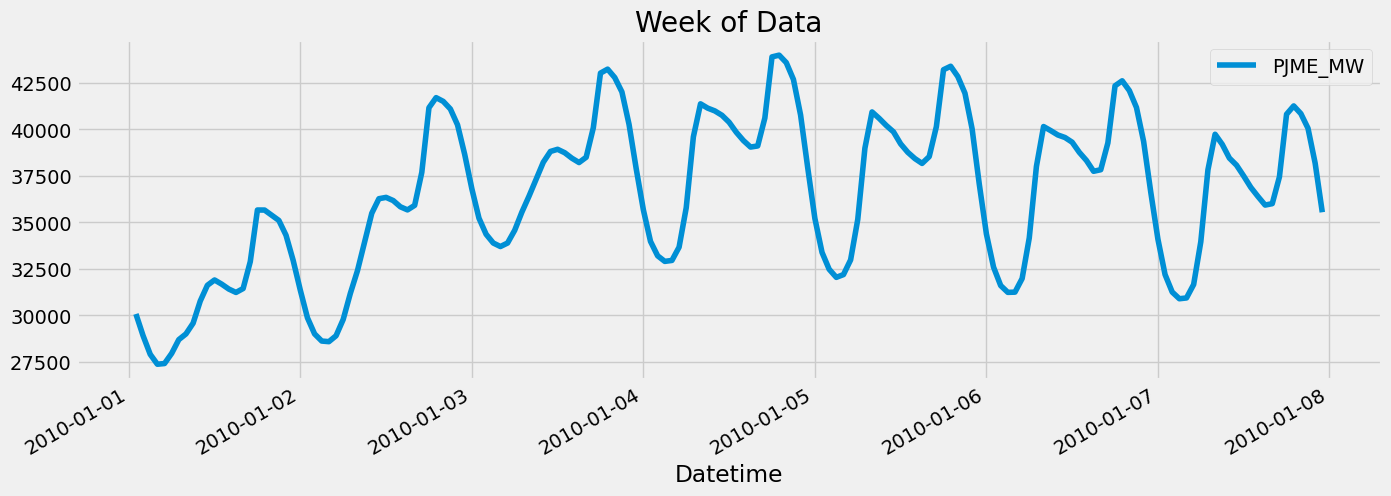

In [20]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title="Week of Data")
plt.show()

It looks like within each day there are two different peaks. This is pretty common in energy consumption and there are also valleys during the nights. It also looks like we have a weekend effect in the beginning, where one of these days actually January 1st would even be a holiday and will be affected by that day either being a weekday or weekend.

# Feature Creation

In [24]:
def create_features(df):
    """
    Create time series features based on time series index.
    
    """
    df = df.copy() # to make sure that we're actually editing a copy of our data frame when we run it through here
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


# Visualize our Feature / Target Relationship

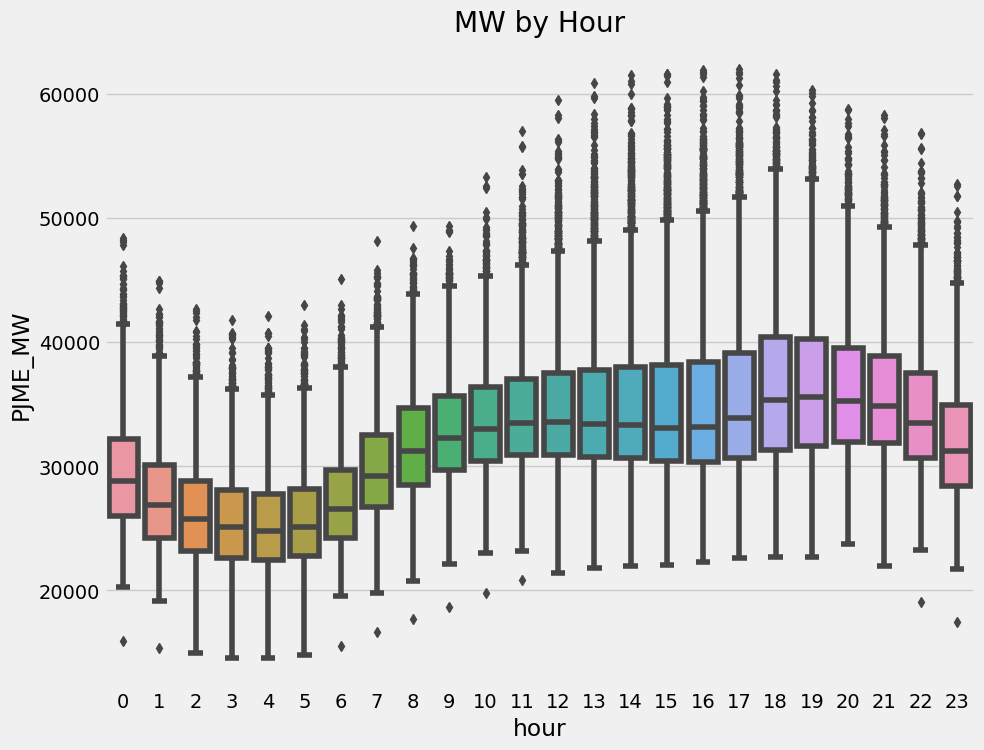

In [22]:
# We can use seaborn boxplot to get an idea of the distribution of data set
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

We can see that early in the morning there seem to be a dip in energy use and it tends to get higher later in the evening.

Next, we can do the same thing with month:

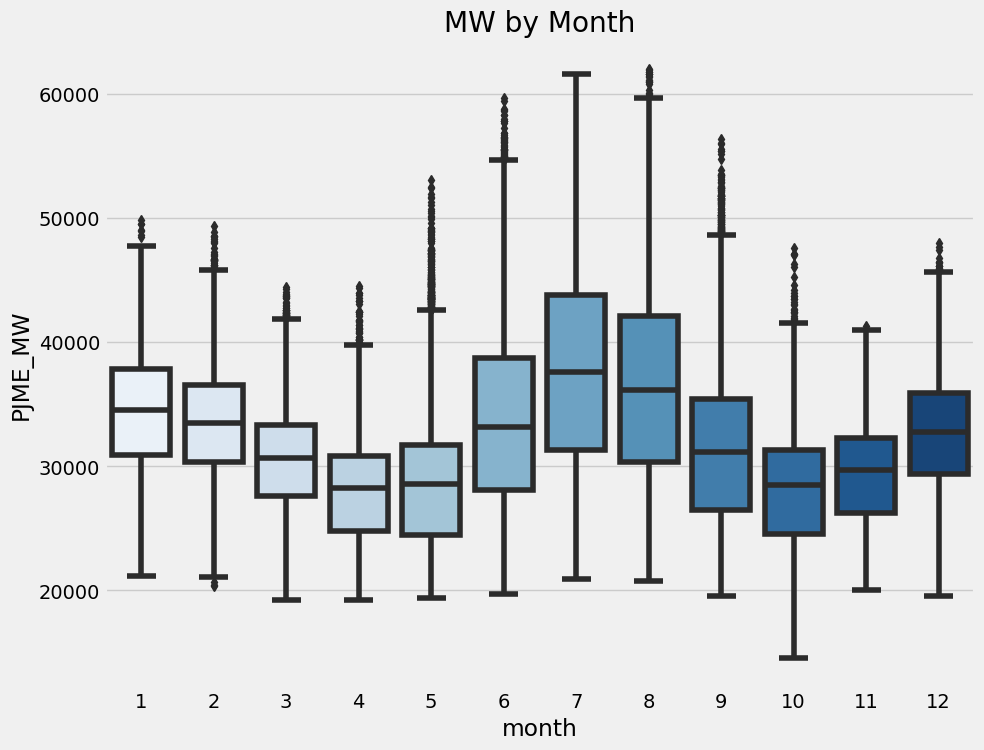

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

We can see that the megawatt usage by month tends to peak two times in the winter season, then in th fall and spring it has lower, and another peak in the middle of summer when everyone's running their AC units.

# Create Our Model

In [25]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [26]:
# XGBoost regression model can be defined by creating an instance of the XGBRegressor class
## n_estimators : The number of trees in the ensemble, often increased until no further improvements are seen.
## max_depth: The maximum depth of each tree, often values are between 1 and 10.

reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', 
                      n_estimators = 1000, 
                      early_stopping_rounds = 50,
                      objective= 'reg:linear',
                       max_depth=3,
                      learning_rate= 0.01) # by lowering the lower_rate we can make sure that it doesn't overfit too quickly
reg.fit(X_train, y_train,
       eval_set= [(X_train, y_train), (X_test, y_test)],
       verbose=100) # verbose=100 tell us just to print out the training and the validation score every 100 trees that are built 

[10:08:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

The root mean squared error starts to go down for both the training set and the test set(or validation set).
If the RMSE starts to get worse at some point, this could be a sign of overfitting which we would like to avoide!

# Feature Importance

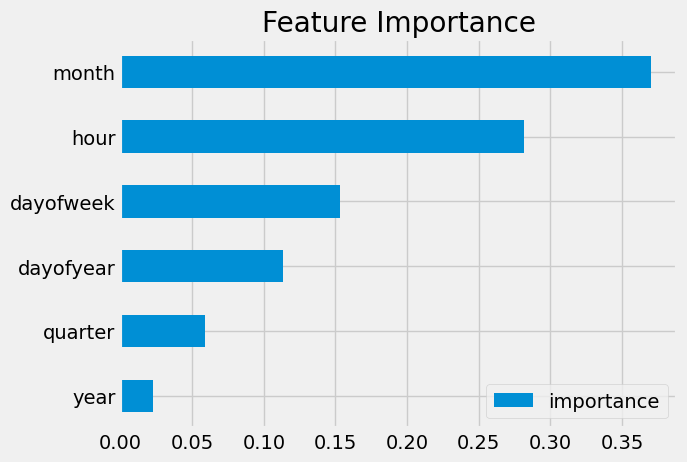

In [28]:
# Feature importances based on how much these features were used in each of the trees built by XGBoostmodel
fi = pd.DataFrame(data = reg.feature_importances_,
                 index = reg.feature_names_in_,
                 columns = ['importance'])
fi.sort_values('importance').plot(kind = 'barh', title='Feature Importance')
plt.show()


Note that there are some overlapping with these types of features.If we removed month dayofyear would just be used in its place. So keep in mind that when you have highly correlated features this feature importance functionality will not tell you exactly how important each feature is individually, more so as a collective in this complete model 

# Forecast on Test

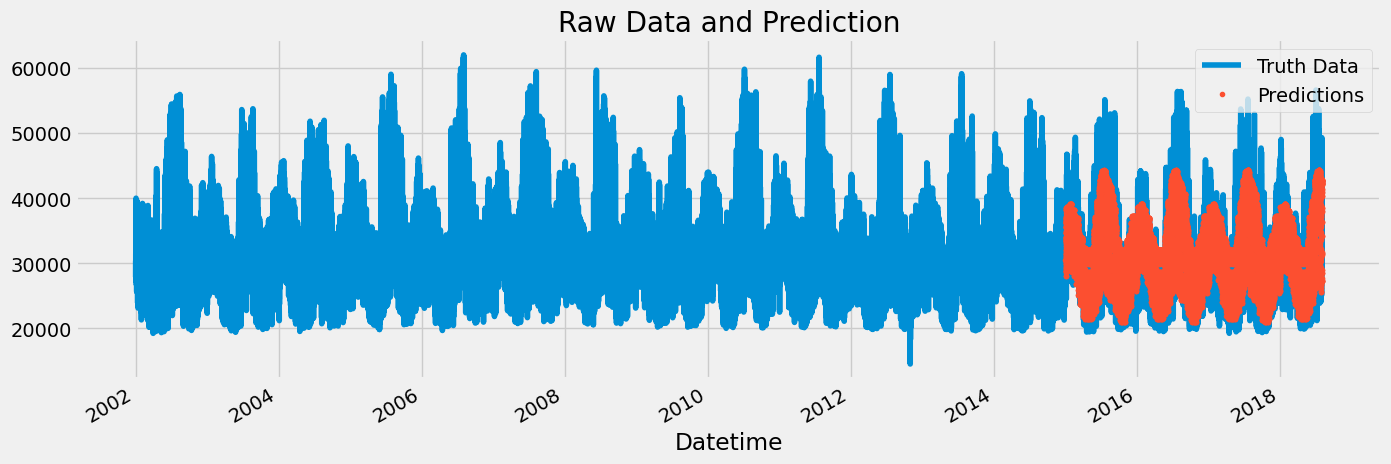

In [29]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how= 'left', left_index=True, right_index=True)

# Plot predictions on top of the training data
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax= ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()


Let's try to take a look at the one week of predictions. We do it for 2018 that's in a Test set:

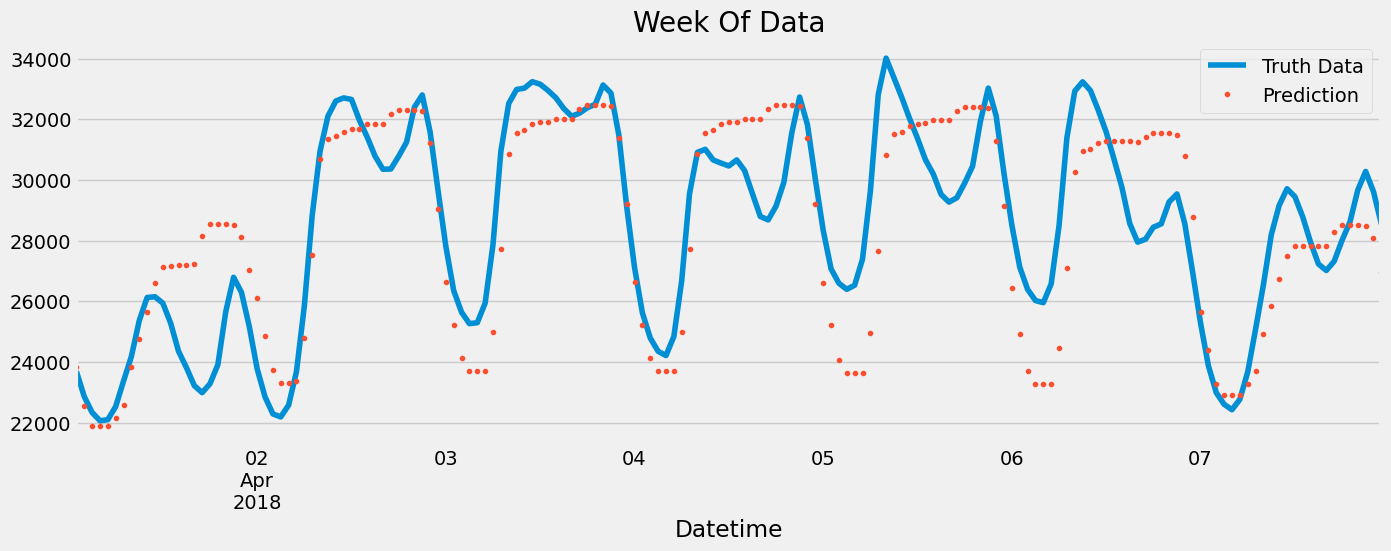

In [30]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

You can see that the model is not perfect. There is a lot of improvements that can be made. some ideas include doing better parameter tuning. We didn't tune this model. We can also add in features for specific days of the year like holidays that might carry forward to either increase or decrease in energy use that it would predict for those days

# Score (RMSE)

In [32]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set : {score:0.2f}')

RMSE Score on Test set : 3721.75


# Calculate Error
Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET]- test['prediction'])
test['date'] = test.index.date # in the test set we take the index and then take the date so that each date is going to have its own value

# Average Error for each day that we've predicted in a descending order to get the worst predicted days
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

In [35]:
# Average Error for each day that we've predicted in a ascending order to get the best predicted days
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-10-24    349.390462
2015-10-28    397.410807
2016-10-27    528.968913
2015-05-06    529.528971
2017-10-15    535.292318
2018-05-16    585.349935
2016-10-08    625.825439
2015-10-03    653.130941
2016-09-16    656.402995
2015-11-06    674.912109
Name: error, dtype: float64

# Next Steps


- More robust cross validation.
- Add more features (weather forecast, holidays)

## Part 2

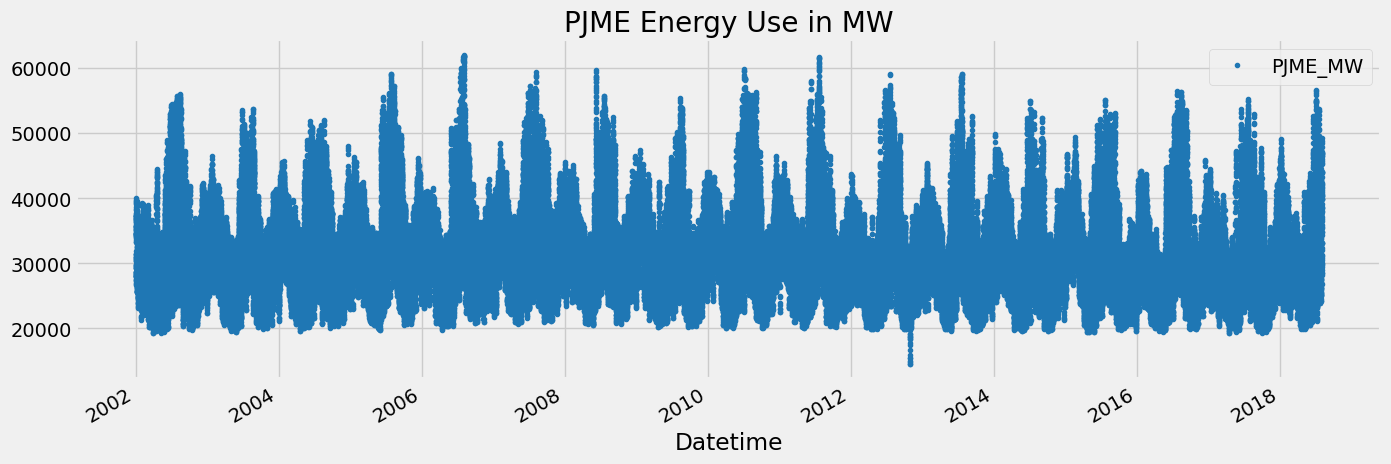

In [54]:
# Load data again:
df = pd.read_csv('Downloads/PJME_hourly/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.plot(style = '.',
        figsize= (15, 5), 
        color=color_pal[0],
        title = 'PJME Energy Use in MW')
plt.show()

# 1. Outlier Analysis and removal

In the first plot, we can notice some really low values around 2012-2013 that seem to be outliers (there might have been a blackout or some problems with sensors at that moment). The model will learn these sort of outliers, unless we remove them.
Next, we are going to look at the histogram of the megawatt data:

<AxesSubplot: ylabel='Frequency'>

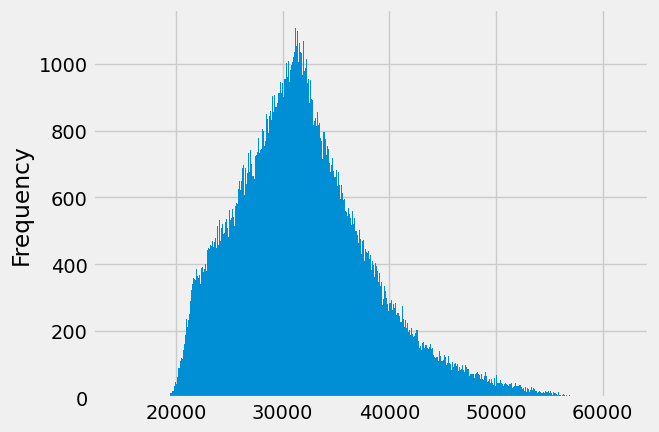

In [45]:
df['PJME_MW'].plot(kind='hist', bins=500)


We can see that most values are between 20000 and peak up a little bit past 50000. To see if there is any extreme outliers that we want to remove, we look at values that are way lower than 20000.

<AxesSubplot: >

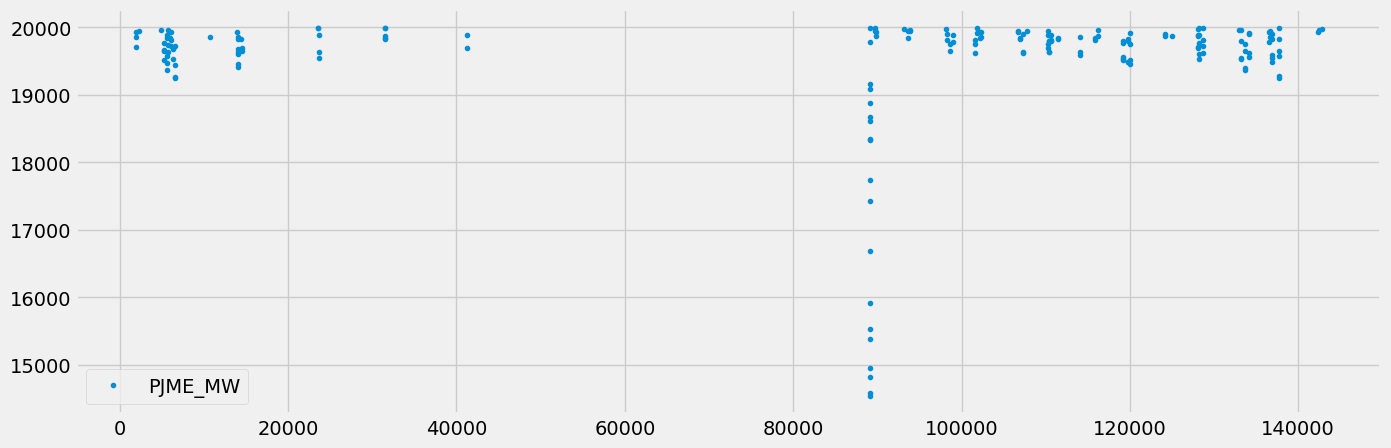

In [46]:
df.query('PJME_MW < 20_000').plot(figsize=(15, 5), style='.')

We can see that the values get under 20000 sometimes but around the middle of the above graph is the area where there definitly are some outliers that don't look like they are legitimate. Next, we can try another threshold, maybe less than 19000, and we can see then just these values that dipped down and these are the values we want to remove from our training and validation sets.

<AxesSubplot: title={'center': 'Outliers'}>

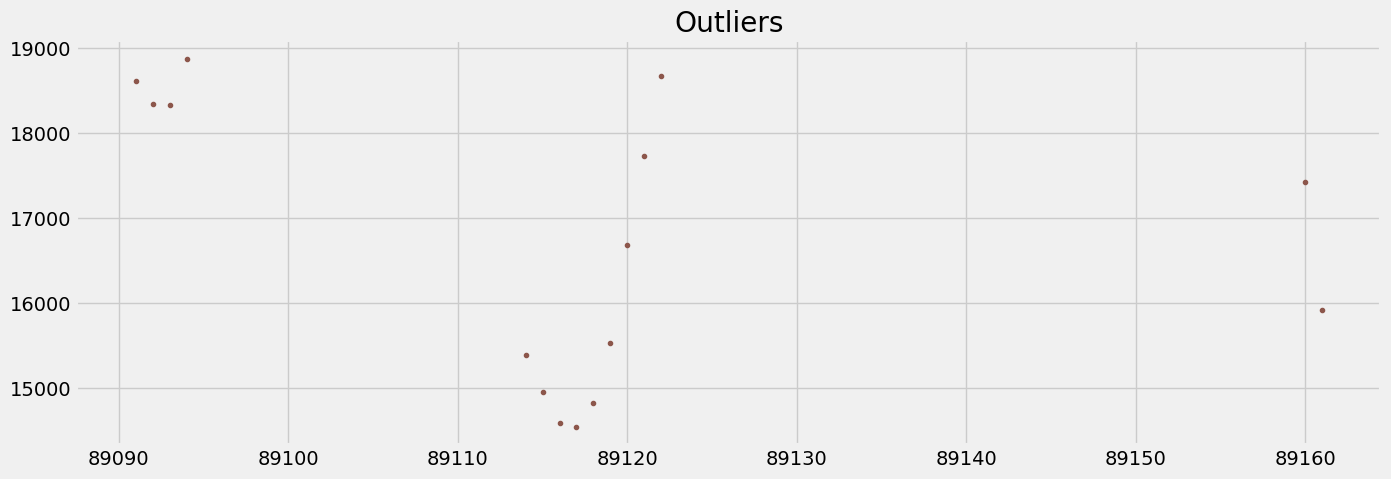

In [47]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [48]:
df = df.query('PJME_MW > 19_000').copy()


# Reviewing: Train / Test Split


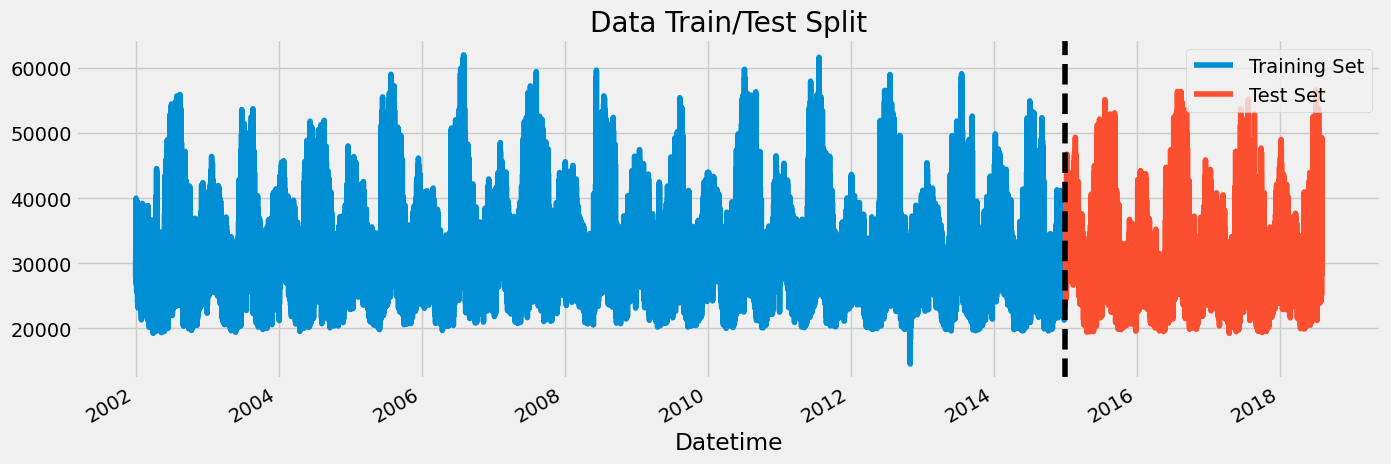

In [55]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In Part 1 we just splitted the data into the training and test set, where the training data is in blue and the data that we evaluated on was this orange test set. But a more robust way to do this is actually to use time series cross validation 

# 2. Time Series Cross Validation

In [56]:
from sklearn.model_selection import TimeSeriesSplit

# because we have hourly energy consumption here and
# we want to let's say predcit out into the future one year.
# so that's going to be 24 hours times 365 days times 1 for one year.
# The gap argument is the gap between the training and the validation set that you're splitting on each time and
#we're going to set that for 24 which will be 24 hours in between when the training set ends and the test set begins:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) 
df = df.sort_index() # we need to sort our dataframe on the index, as if not sorted this time series split will not work

tss object is just a generator. So the way we run on this generator is looping over it and applying it to the training and test data sets (for train_idx, val_idx in tss.split(df)). train_idx will provide us the indices in our data frame which will be our training set and val_idx will provide us the indices for our validation set, and we will be able to loop over this five times since we set the n_splits=5.
In the next step, we are going to make a one subplot for each of these 5 splits so we can see them. With the argument sharex= True, the x-axis is the same for all subplots.
we start with fold = 0 and increment each time, and in each time we plot our training set and test set.

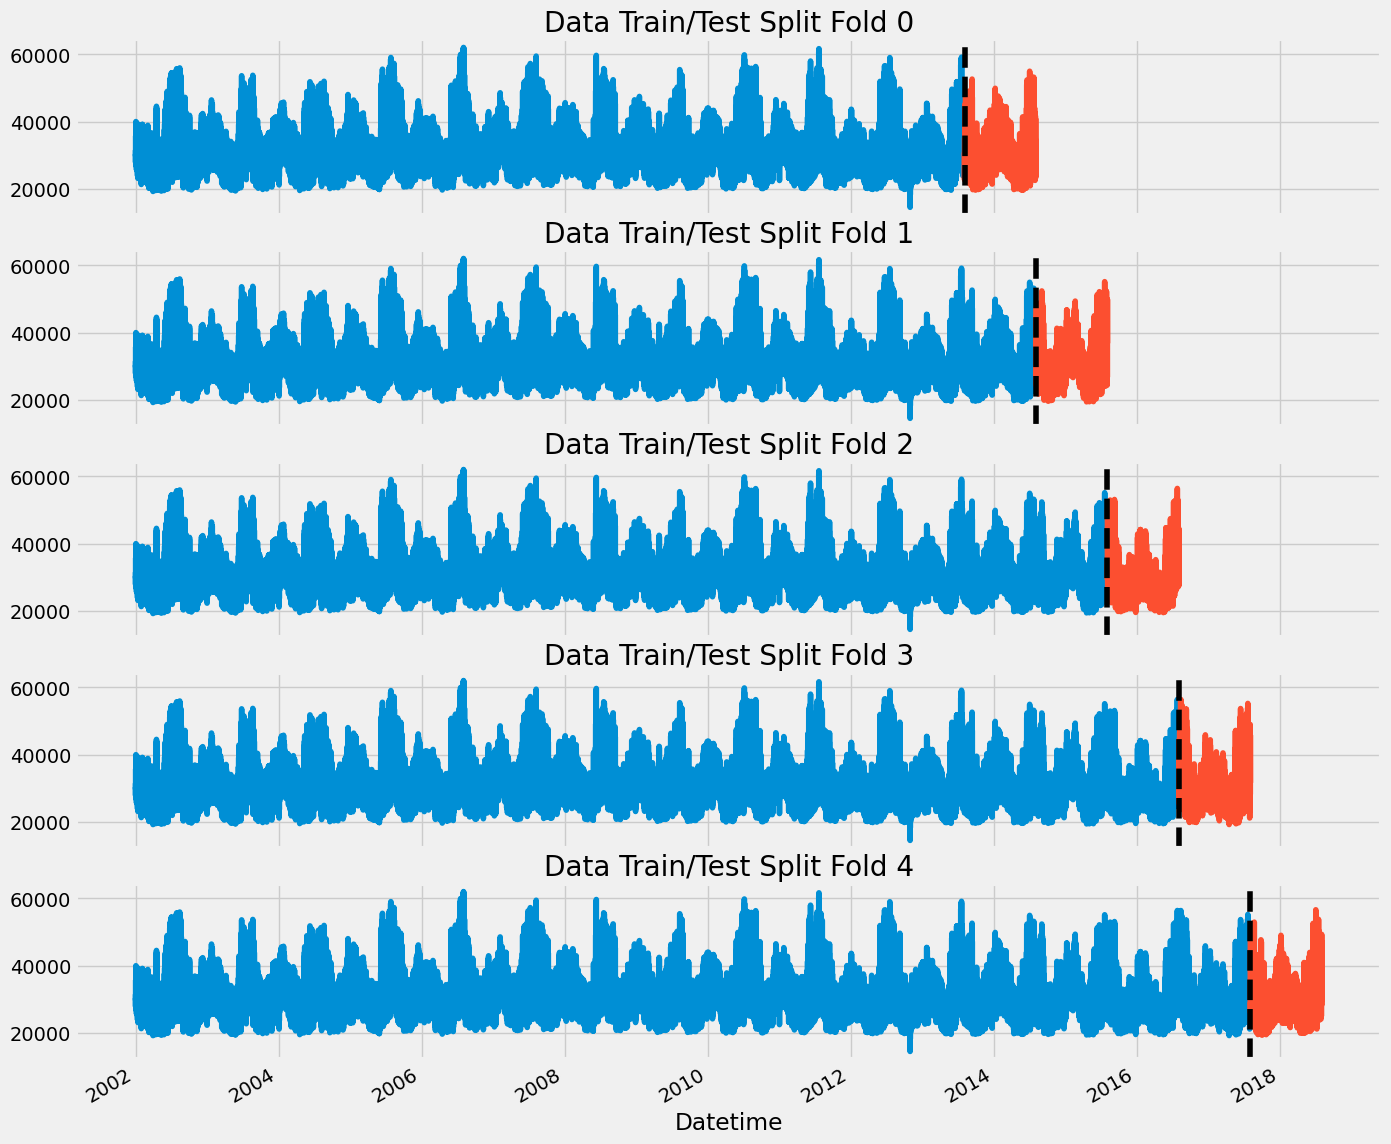

In [57]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx] # training data set is when the dataframe is train index
    test = df.iloc[val_idx] # validation/test data set is when the dataframe is validation index
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In the figure above we can see how each fold works. It's going back in time and then we have one year of validation set each fold. And because we have a lot of training data going way back into history we can actually do this five different times with no problem where we are actually testing each of the last five years independently from each other. Now, it's important to do it this way we wouldn't want to just take out this first year (2015) and then train on data from after it because that would be in some ways a leak about our target into this validation data and when we are running this we are going to be doing cross-validation we want to make sure that it is as leak free as possible.

# 3. Forecasting Horizon Explained
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).



In [58]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 4. Lag Features
What was the target (x) days in the past. 
We tell the model to look back into the past x days and to use the target values for that many days(x) in the past as a new feature that you feed into the model. 
We're going to use a dictionary for mapping these lag features into our dataframe (target_map).
Next, we take the data frame index for every day and substract a Timedelta(which is some days into the past, e.g., 364) from our index day. This then will be this same day last year on the same day of the week, and finally we map this on our target using target_map dictionary that we created.


In [59]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [60]:
df = add_lags(df)

# Train Using Cross Validation


In [61]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[12:08:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32730.71054	validation_1-rmse:31956.75630
[100]	validation_0-rmse:12532.14660	validation_1-rmse:11907.51481
[200]	validation_0-rmse:5744.29363	validation_1-rmse:5356.76730
[300]	validation_0-rmse:3867.98731	validation_1-rmse:3894.92676
[400]	validation_0-rmse:3432.78115	validation_1-rmse:3757.49592
[468]	validation_0-rmse:3340.69128	validation_1-rmse:3765.23730
[12:09:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32670.51840	validation_1-rmse:32138.89448
[100]	validation_0-rmse:12513.25084	validation_1-rmse:12221.99536
[200]	validation_0-rms

In [62]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3753.8848
Fold scores:[3756.0846993452606, 3423.279064157108, 3475.8356869795707, 4117.118441255748, 3997.1059173998297]


# 5. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [63]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500, # we changed here the n_estimators to 500, because from results above it appears that after 500 iterations there is a chance of overfitting
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[12:22:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32402.65859
[100]	validation_0-rmse:12426.28053
[200]	validation_0-rmse:5751.94624
[300]	validation_0-rmse:3972.75300
[400]	validation_0-rmse:3573.05471
[499]	validation_0-rmse:3457.78460


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [64]:
df.index.max()


Timestamp('2018-08-03 00:00:00')

we can see that our training data goes up until 2018-08-03, so we will take this date and actually make this the first day of our future data  frame that we're going to create, and just to be safe we will just go up until the first day of that month as our last date

In [65]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [66]:
future_w_features = df_and_future.query('isFuture').copy()


# Predict the future

In [67]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


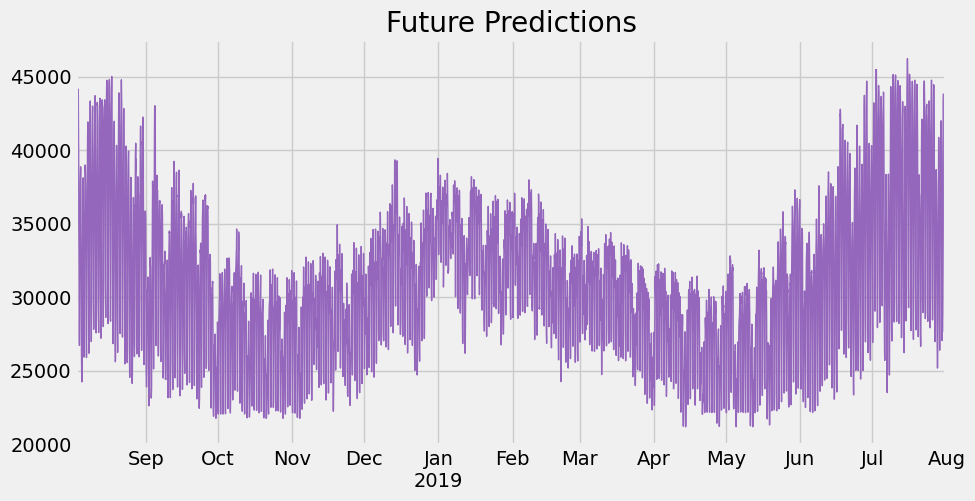

In [68]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()


# Bonus: Saving Model For later

In [69]:
# Save model
reg.save_model('model.json')


In [70]:
!ls -lh


'ls' is not recognized as an internal or external command,
operable program or batch file.


<AxesSubplot: title={'center': 'Future Predictions'}>

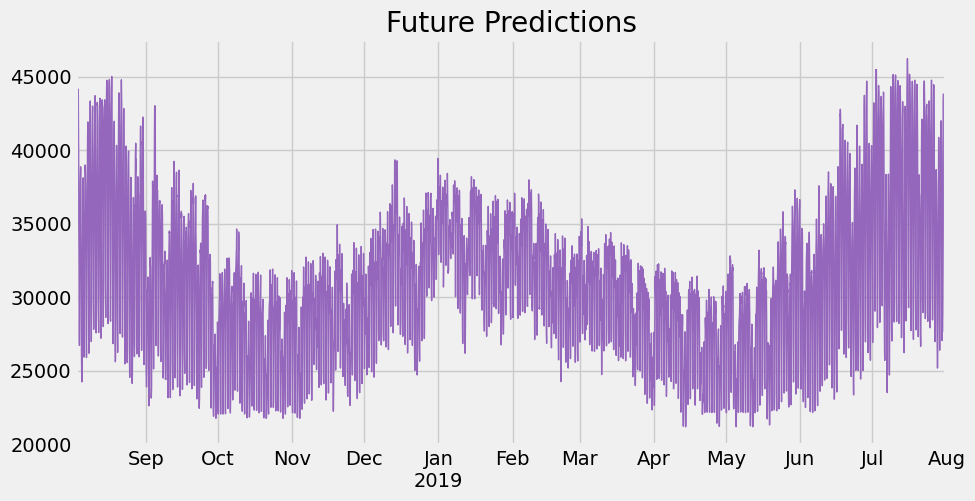

In [71]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')